# Cell-to-Graph CellEncoding Lifting Tutorial

***
This notebook shows how to import a dataset, (preprocess it to a CellComplex) and lift it with **CellEncodingLifting** to a graph. 

The notebook is divided into sections:

- [Loading the dataset](#loading-the-dataset) loads the config files for the data, applies the **CellEncoding Lifting** to lift it to a graph and visualizes it.
- [Loading and applying the lifting](#loading-and-applying-the-lifting) defines a simple neural network to test that the lifting creates the expected incidence matrices.
- [Create and run a simplicial nn model](#create-and-run-a-simplicial-nn-model) simply runs a forward pass of the model to check that everything is working as expected.

***
***

Note that for simplicity the notebook is setup to use a simple cell complex. 
***

### Imports and utilities

In [1]:
# With this cell any imported module is reloaded before each cell execution
%load_ext autoreload
%autoreload 2
from modules.data.load.loaders import CellComplexLoader
from modules.data.preprocess.preprocessor import PreProcessor
from modules.utils.utils import (
    describe_data,
    load_dataset_config,
    load_model_config,
    load_transform_config,
)

## Loading the dataset

Here we just need to spicify the name of the available dataset that we want to load. First, the dataset config is read from the corresponding yaml file (located at `/configs/datasets/` directory), and then the data is loaded via the implemented `Loaders`.


In [2]:
dataset_name = "manual_cell_complex"
dataset_config = load_dataset_config(dataset_name)
loader = CellComplexLoader(dataset_config)


Dataset configuration for manual_cell_complex:

{'data_domain': 'cell_complex',
 'data_type': 'toy_dataset',
 'data_name': 'manual_cell_complex',
 'data_dir': 'datasets/cell_complex/toy_dataset',
 'num_features': 1,
 'num_classes': 2,
 'task': 'classification',
 'loss_type': 'cross_entropy',
 'monitor_metric': 'accuracy',
 'task_level': 'node'}


We can then access to the data through the `load()`method:


Dataset only contains 1 sample:


Processing...
Done!


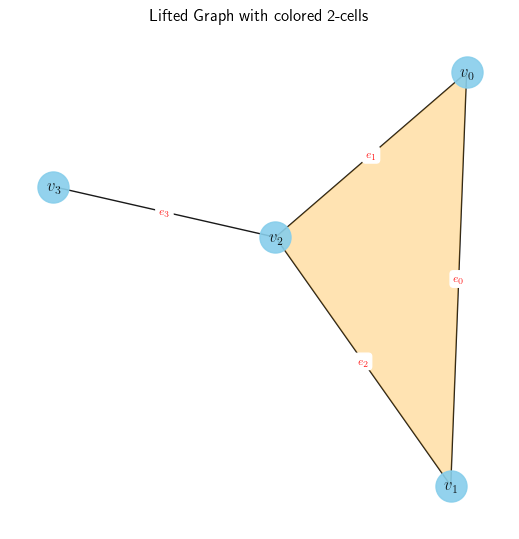

 - The complex has 4 0-cells.
 - The 0-cells have features dimension 1
 - The complex has 4 1-cells.
 - The 1-cells have features dimension 1
 - The complex has 1 2-cells.
 - The 2-cells have features dimension 1



In [3]:
dataset = loader.load()
describe_data(dataset)

## Loading and Applying the Lifting

In this section we will instantiate **CellEncoding** lifting [[1]](https://openreview.net/pdf?id=HKUxAE-J6lq). The lifting takes a cell complex $X$ as source domain and transforms it to a graph $G_X$ as destination domain. Each cell $P_X$ becomes a vertex in $G_X$, such that $V_X=P_X$. Those vertices are connected via two rules:
1. Two cells $\tau, \delta \in P_X$ have a direct boundary relationship.
2. Two cells $\tau, \delta \in P_X$ share a common higher-dimensional cell.
If either rule apllies to a pair of cells, their corresponding vertices in $G_X$ get connected with an edge.

Additionally each vertex gets an encoding that corresponds to the one-hot encoded cell dimension. 

***
[[1]](https://openreview.net/pdf?id=HKUxAE-J6lq) Jogl, Fabian, Maximilian Thiessen, and Thomas Gärtner. "Reducing learning on cell complexes to graphs." ICLR 2022 Workshop on Geometrical and Topological Representation Learning. 2022.
***

In [4]:
# Define transformation type and id
transform_type = "liftings"
# If the transform is a topological lifting, it should include both the type of the lifting and the identifier
transform_id = "cell2graph/cell_encoding_lifting"

# Read yaml file
transform_config = {
    # "pre_lifting": load_transform_config(pre_transform_type, pre_transform_id),
    "lifting": load_transform_config(transform_type, transform_id)
    # other transforms (e.g. data manipulations, feature liftings) can be added here
}


Transform configuration for cell2graph/cell_encoding_lifting:

{'transform_type': 'lifting',
 'transform_name': 'CellEncodingLifting',
 'feature_lifting': 'ProjectionSum'}


We than apply the transform via our `PreProcesor`:


Dataset only contains 1 sample:


Processing...
Done!


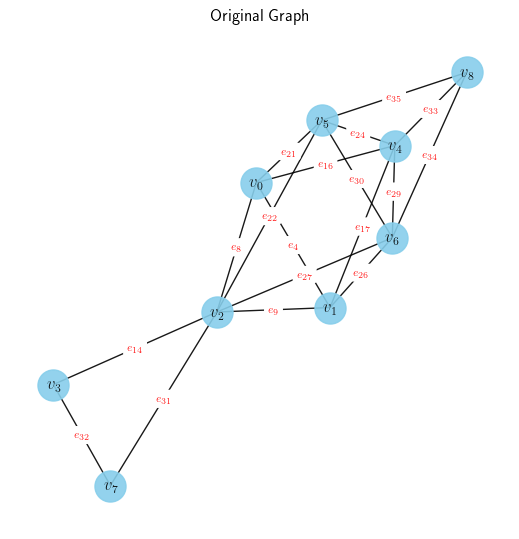

 - Graph with 9 vertices and 36 edges.
 - Features dimensions: [3, 0]
 - There are 0 isolated nodes.



In [5]:
lifted_dataset = PreProcessor(dataset, transform_config, loader.data_dir)
describe_data(lifted_dataset)

In [6]:
lifted_dataset.get(0)

Data(x=[9, 3], edge_index=[2, 36], shape=[2], num_nodes=9)

Since the **CellEncoding** lifting updates the feature dimension (by encoding the cell dimension), we need to update the value in `dataset_config` accordingly. 

In [7]:
dataset_config["num_features"] = 3

## Create and Run a Cell NN Model

In this section a simple model is created to test that the used lifting works as intended. In this case the model uses the `x_0`, `x_1`, `x_2` which are the features of the nodes, edges and cells respectively. It also uses the `adjacency_1`, `incidence_1` and `incidence_2` matrices so the lifting should make sure to add them to the data.

In [8]:
from modules.models.graph.gcn import GCNModel

model_type = "graph"
model_id = "gcn"
model_config = load_model_config(model_type, model_id)

model = GCNModel(model_config, dataset_config)


Model configuration for graph GCN:

{'in_channels': None, 'hidden_channels': 32, 'out_channels': None}


In [9]:
y_hat = model(lifted_dataset.get(0))

If everything is correct the cell above should execute without errors. 